In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

from utilities.script.image_utils import load_numpy_dataset, show_image_number, dataset_ratio_check

In [2]:
# Load dataset based on K-fold
K = 4
train_dataset_load_path = np.load("utilities/data/"+ str(K) + "/train_"+ str(K) + ".npz")
test_dataset_load_path = np.load("utilities/data/"+ str(K) + "/test_"+ str(K) + ".npz")

train_dataset, test_dataset = load_numpy_dataset(train_dataset_load_path, test_dataset_load_path, K)

x_train, y_train = train_dataset
x_test, y_test = test_dataset

['paper' 'rock' 'scissors']
Corresponding label : rock


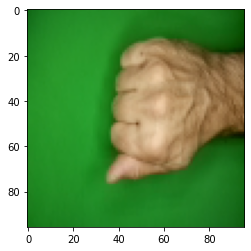

In [3]:
# Show loaded sample
SAMPLE_INDEX = 300
show_image_number(x_test[SAMPLE_INDEX], y_test[SAMPLE_INDEX])

In [4]:
dataset_ratio_check(y_test)

Class=0, n=188 (34.559%)
Class=1, n=181 (33.272%)
Class=2, n=175 (32.169%)


In [5]:
#x_train, y_train = tf.convert.to_tensor(x_train, dtype=tf.float32), tf.convert.to_tensor(y_train, dtype=tf.int8)
#x_test, y_test = tf.convert.to_tensor(x_test, dtype=tf.float32), tf.convert.to_tensor(y_test, dtype=tf.int8)

In [6]:
# Preserve real label in numerical
y_train_numeric, y_test_numeric = y_train.copy(), y_test.copy()

In [7]:
from tensorflow.experimental import numpy as tnp

x_train, x_test = tnp.asarray(x_train), tnp.asarray(x_test)
y_train, y_test = tnp.asarray(y_train), tnp.asarray(y_test)

In [8]:
# Switch the labels into categorical

y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [9]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 15:
        return 0.0005
    elif epoch >= 15:
        return 0.0001

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [10]:
LEARNING_RATE = 0.001

def define_model(optimizer):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(96, 96, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    return model

In [11]:
model = define_model(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler(0)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0

In [12]:
with tf.device("/device:GPU:0"):
    history_adam = model.fit(x_train, y_train, epochs=20, batch_size=8, validation_data=(x_test, y_test))

Epoch 1/20
205/205 [==============================] - 14s 61ms/step - loss: 0.6313 - accuracy: 0.7046 - val_loss: 0.3253 - val_accuracy: 0.8989
Epoch 2/20
205/205 [==============================] - 12s 59ms/step - loss: 0.1469 - accuracy: 0.9523 - val_loss: 0.3513 - val_accuracy: 0.8971
Epoch 3/20
205/205 [==============================] - 12s 59ms/step - loss: 0.1105 - accuracy: 0.9645 - val_loss: 0.0895 - val_accuracy: 0.9743
Epoch 4/20
205/205 [==============================] - 12s 59ms/step - loss: 0.0736 - accuracy: 0.9768 - val_loss: 0.0858 - val_accuracy: 0.9724
Epoch 5/20
205/205 [==============================] - 12s 59ms/step - loss: 0.0459 - accuracy: 0.9847 - val_loss: 0.0912 - val_accuracy: 0.9706
Epoch 6/20
205/205 [==============================] - 12s 59ms/step - loss: 0.0271 - accuracy: 0.9872 - val_loss: 0.0896 - val_accuracy: 0.9798
Epoch 7/20
205/205 [==============================] - 12s 60ms/step - loss: 0.0292 - accuracy: 0.9914 - val_loss: 0.0882 - val_accuracy:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


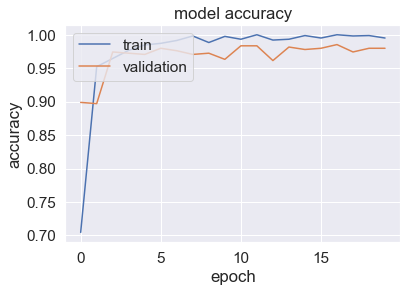

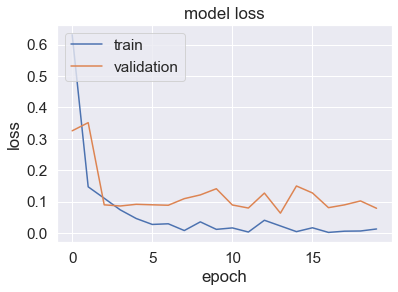

In [17]:
%load_ext autoreload
%autoreload 2


from utilities.script.validation_utils import get_training_plot, get_confusion_matrix, get_classification_report

get_training_plot(history_adam, metric='accuracy', save=True, savepath="weight/shallow/doc/acc_" + str(K) + ".jpg")
get_training_plot(history_adam, metric='loss', save=True, savepath="weight/shallow/doc/loss_" + str(K) + ".jpg")

17/17 [==============================] - 1s 48ms/step

Confusion Matrix



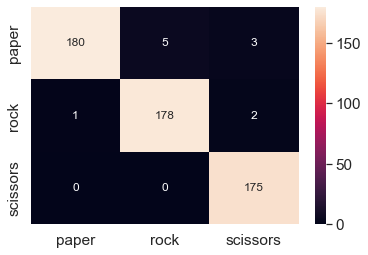

          paper  rock  scissors
paper       180     5         3
rock          1   178         2
scissors      0     0       175


In [18]:
y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
get_confusion_matrix(y_test_numeric, y_pred, save=True, savepath="weight/shallow/doc/confmat_" + str(K) + ".jpg")

In [19]:
get_classification_report(y_test_numeric, y_pred)



Classification Report

              precision    recall  f1-score   support

       paper       0.99      0.96      0.98       188
        rock       0.97      0.98      0.98       181
    scissors       0.97      1.00      0.99       175

    accuracy                           0.98       544
   macro avg       0.98      0.98      0.98       544
weighted avg       0.98      0.98      0.98       544



In [20]:
model.save("weight/shallow/shallow_"+ str(K) + ".h5")

In [22]:
model_json = model.to_json()
with open("weight/shallow/shallow_"+ str(K) + ".json", "w") as json_file:
    json_file.write(model_json)